In [1]:
require(tidyr)
require(ggplot2)

Loading required package: tidyr
Loading required package: ggplot2


In [2]:
cubicDF = read.csv("../Results/cubic_model.csv")
flschDF = read.csv("../Results/full_scholfield_model.csv")
nhschDF = read.csv("../Results/noh_scholfield_model.csv")
nlschDF = read.csv("../Results/nol_scholfield_model.csv")
arrhnDF = read.csv("../Results//arrhenius_model.csv")

aicdf = data.frame("NewID" = cubicDF$NewID,
                  "cubic" = cubicDF$aic,
                  "flsch" = flschDF$aic,
                  "nhsch" = nhschDF$aic,
                  "nlsch" = nlschDF$aic,
                  "arrhn" = arrhnDF$aic)

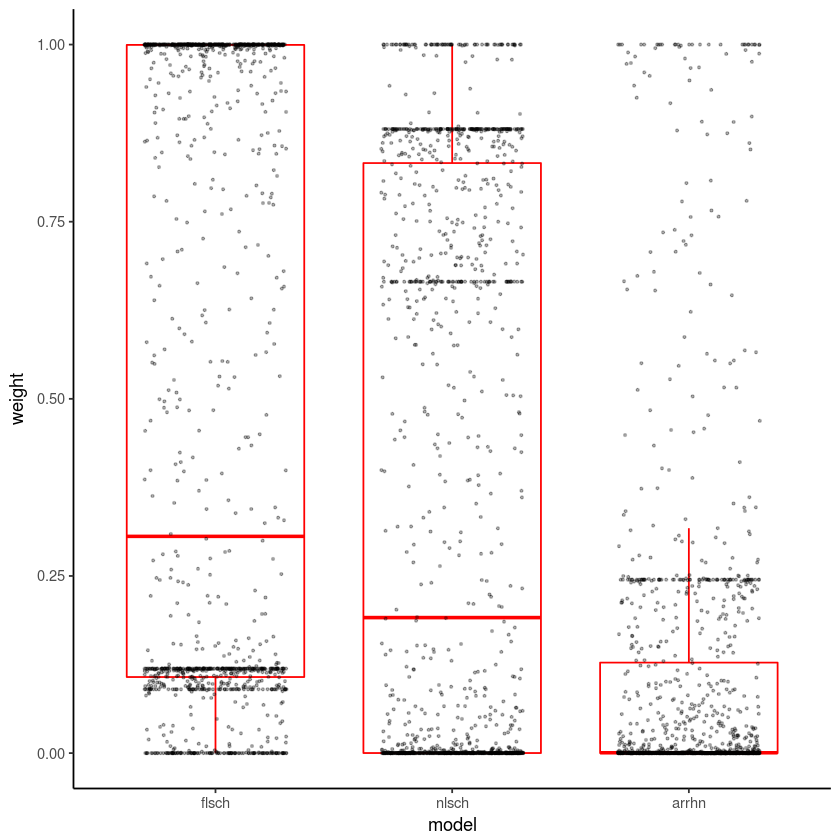

In [9]:
#mdls = c("cubic", "flsch", "nhsch", "nlsch", "arrhn")#
mdls = c("flsch", "nlsch", "arrhn")

delta = function(row, model){
    abs(min(row, na.rm = TRUE) - row[model])
}

weight = function(row, model_delta, comparing){
    if (is.na(row[model_delta])){
        0
    } else{
        exp(-.5*row[model_delta])/sum(exp(-.5*row[comparing]), na.rm = TRUE)
    }
}

compare = function(models){

    DFaic    = paste0(models, "DF$aic")
    DFdelta  = paste0(models, "_delta")
    DFweight = paste0(models, "_weight")


    aicDF = data.frame("NewID" = eval(parse(text = (paste0(models[1], "DF$NewID")))))

    for (i in 1:length(models)){
        aicDF = cbind(aicDF, eval(parse(text = DFaic[i])))
    }
    
    colnames(aicDF) = c("NewID", models)
    
    for (i in 1:length(models)){
    aicDF[DFdelta[i]] = apply(aicDF, 1, delta, model = mdls[i])
    }

    for (i in 1:length(models)){
    aicDF[DFweight[i]] =  apply(aicDF, 1, weight, model_delta = DFdelta[i],
                               comparing = DFdelta)
    }
    
    
    pltDF = data.frame(NewID  = aicDF$NewID, model = mdls[1],
                   aic    = eval(parse(text = DFaic[1])),
                   delta  = eval(parse(text = paste0("aicDF$",DFdelta[1]))), 
                   weight = eval(parse(text = paste0("aicDF$",DFweight[1]))))

    for(i in 2:length(mdls)){
        pltDF = rbind.data.frame(pltDF,
                                 data.frame(NewID  = aicDF$NewID, model = models[i],
                                            aic    = eval(parse(text = DFaic[1])),
                                            delta  = eval(parse(text = paste0("aicDF$",DFdelta[i]))), 
                                            weight = eval(parse(text = paste0("aicDF$",DFweight[i])))))
    }
    
    plt = ggplot(data = pltDF, aes(y = weight, x = model))
    plt = plt + geom_boxplot(outlier.shape=NA, colour = "red")
    plt = plt + geom_jitter(position=position_jitter(width=.3, height=0), alpha = 0.3, cex = .5)
    plt = plt + theme_classic()
    print(plt)

    return(pltDF)
}

pltDF = compare(mdls)


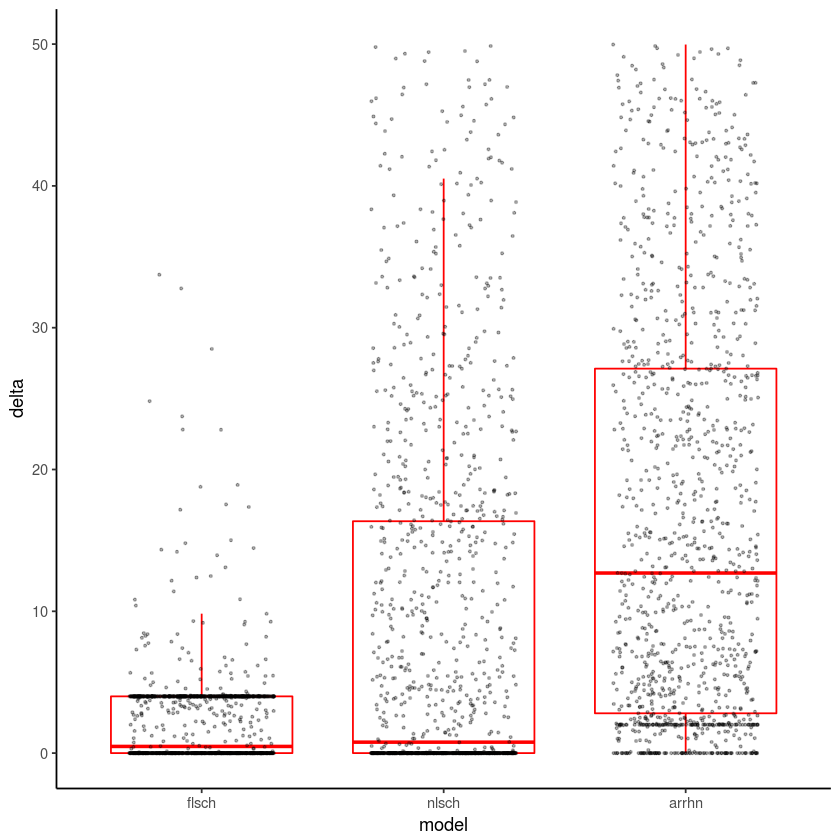

In [15]:
a = subset(pltDF, delta < 50)

plt = ggplot(data = a, aes(y = delta, x = model))
plt = plt + geom_boxplot(outlier.shape=NA, colour = "red")
plt = plt + geom_jitter(position=position_jitter(width=.3, height=0), alpha = 0.3, cex = .5)
plt = plt + theme_classic()
print(plt)

In [12]:
subset(pltDF, aic < 25 & aic > -50)

,NewID,model,aic,delta,weight
1,1,flsch,-27.209991,4.0000000,1.189505e-01
2,3,flsch,-15.076779,3.9999998,1.192003e-01
3,4,flsch,16.576019,32.7683619,7.652329e-08
4,5,flsch,-41.087373,4.0000000,1.190562e-01
5,8,flsch,-14.444647,4.0000000,1.191244e-01
6,9,flsch,-7.775662,2.9723493,1.536585e-01
7,10,flsch,-24.301187,3.5349563,1.251314e-01
8,11,flsch,-12.182891,4.0000005,1.176534e-01
9,12,flsch,-18.863657,4.0000011,1.130575e-01
10,13,flsch,0.825483,3.9896293,9.022429e-02


In [6]:
a = aicDF[which(aicDF$arrhn_weight > 0.244),]
a = a[which(a$arrhn_weight < 0.246),]
nrow(a)

[1] 66

In [7]:
a

,NewID,flsch,nlsch,arrhn,flsch_delta,nlsch_delta,arrhn_delta,flsch_weight,nlsch_weight,arrhn_weight
14,17,-3.7151168,-7.7151168,-5.715117,4.000000,0,2.000000,0.09003057,0.6652410,0.2447285
15,18,-3.8296708,-7.8296717,-5.829671,4.000001,0,2.000000,0.09003054,0.6652410,0.2447285
16,19,-40.4528411,-44.4528459,-42.452846,4.000005,0,2.000000,0.09003038,0.6652411,0.2447285
202,514,-8.7447491,-12.7447491,-10.742295,4.000000,0,2.002454,0.09005760,0.6654407,0.2445017
208,520,-8.7897840,-12.7897840,-10.789784,4.000000,0,2.000000,0.09003058,0.6652410,0.2447284
213,526,-0.4569896,-4.4569896,-2.456989,4.000000,0,2.000000,0.09003057,0.6652410,0.2447285
233,588,3.6077854,-0.3922148,1.607785,4.000000,0,2.000000,0.09003057,0.6652410,0.2447285
275,652,-25.8959475,-29.8959493,-27.895949,4.000002,0,2.000001,0.09003050,0.6652411,0.2447284
277,654,-20.6019060,-24.6019064,-22.601452,4.000000,0,2.000454,0.09003556,0.6652780,0.2446865
299,685,-16.1897391,-20.1897391,-18.189739,4.000000,0,2.000000,0.09003057,0.6652410,0.2447285


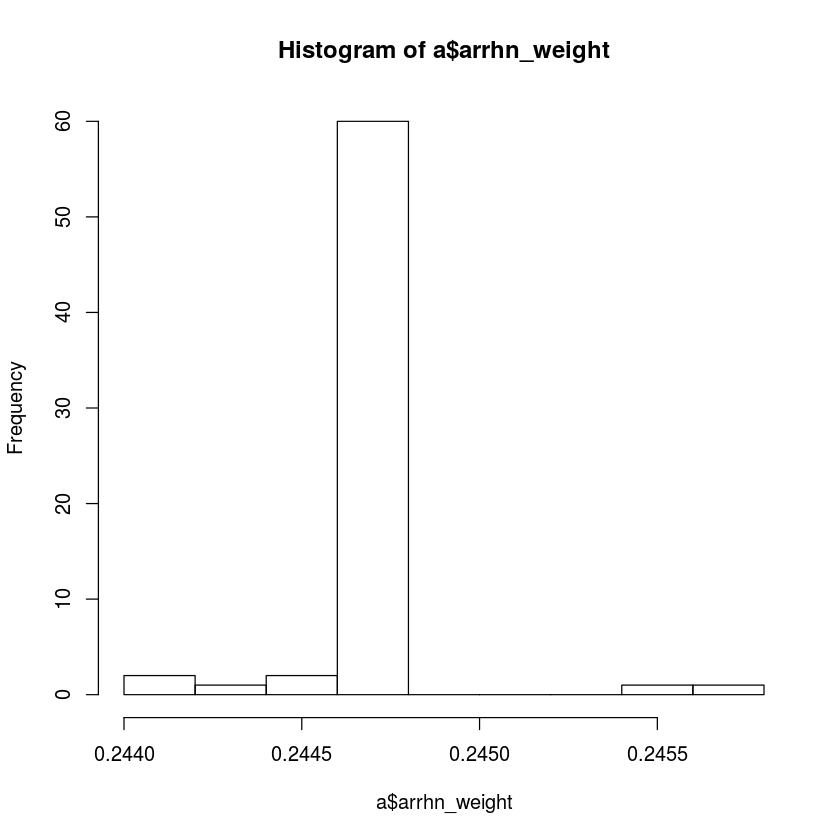

In [253]:
hist(a$arrhn_weight)